![image info](/images/plot_surface_animation_funcanimation.gif)

The PINN is a mash-free approach that solves PDE by posing a mathematical model in the form of a neural network (NN) where the loss function incorporates a residual term from the equation of interest. The residual term restricts the space of acceptable solutions in accordance with imposed physics (laws that are derived to model observed reality). Thus generally, PINNS are able to solve the PDEs in the following form
$$\mathcal{F}(U(z);\gamma=f(z)),\,\,\,\, z\,\, in\,\, \Omega$$
$$\mathcal{B}(U(z);\gamma=g(z)),\,\,\,\, z\,\, in\,\, \partial\Omega$$
Let's list the components needed for the full definition as follows:
- $\partial\Omega$ stands for boundaries on a domain $\Omega \subset{\mathbb{R}^d}$
- $z := \mathcal{\left[x_1,...,x_{d-1}; t\right]}$ is the space-time coordinate vector <br>
- Networks's inputs are transformed into networks outputs field $u$
- $\gamma$ are the parameters related to the physics <br>
- $f$  refers to a function that identifies the data of the problem<br>
- $\mathcal{F}$ is the non-linear differential operator <br>
- $g$ is a boundary function<br>
- $\mathcal{B}$ is the non-linear boundary operator

PINNs can solve both forward and inverse problems. The first finds the function $u$ for every $f$ with $\omega$ as specified parameters. In the latter, $\gamma$ is deduced from data. <br>
Therefore there is the NN approximation parametrized by $\theta$
$$\hat{u}_{\theta}(z)\simeq u(z)$$
in which NN learns to approximate the PDE via finding $\theta$ that defines the NN by minimising the adequately weighted loss function depending on differential equation $\mathcal{L}_{\mathcal{F}}$, the boundary conditions $\mathcal{L}_{\mathcal{B}}$ and, if available, some data $\mathcal{L}_{data}$. Namely,
$$\theta^* = \displaystyle \min_{x}arg(\omega_{\mathcal{F}}\mathcal{L}_{\mathcal{F}}(\theta)+\omega_{\mathcal{B}}\mathcal{L}_{\mathcal{B}}(\theta)+\omega_{\mathcal{data}}\mathcal{L}_{data}(\theta))$$ 

From the above, we can consider PINNs as unsupervised learning if only based on a physical equation. However, we can say about semi-supervised learning if we have boundary conditions. The incorporation of known label data results in supervised learning. The diagram below depicts the conceptual architecture of PINNs
![image info](/images/pinns.png)
Image taken from [*Scientific Machine Learning through
Physics-Informed Neural Networks: Where
we are and What’s next*](https://arxiv.org/pdf/2201.05624.pdf) by Cuomo, Salvatore and Di Cola, Vincenzo Schiano and Giampaolo, Fabio and Rozza, Gianluigi and Raissi, Maizar and Piccialli, Francesco, 2022.

Here, we will solve the Heat equation $U_t=U_{xx}$ with Dirichlet boundary conditions, homogeneous $U(0,t)=0$ and non-homogeneous $U(1,t)=sin(2t)$, together with the initial condition $U(x,0)=\sqrt{x}$. Non-homogeneous solutions can cause difficulties, i.e. it is often not straightforward to obtain stable convergence and model overfits easily. The problem can be overcome by applying bespoke NN architecture and/or [Fourier Features](https://arxiv.org/pdf/2006.10739.pdf). The analytical solution was obtained through Mathematica in the form of two terms of expansion of the solution and is plotted below. For the residual term, we have 200x100 = 20000 points from which we will sample points, namely collocation points inside the domain, $\Omega$.

CUDA available:  True
PyTorch version:  1.12.1
torch.Size([200, 1])
torch.Size([100, 1])
torch.Size([200, 100])
torch.Size([200, 100])


/tmp/ipykernel_21479/1662213473.py:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cp) # Add a colorbar to a plot


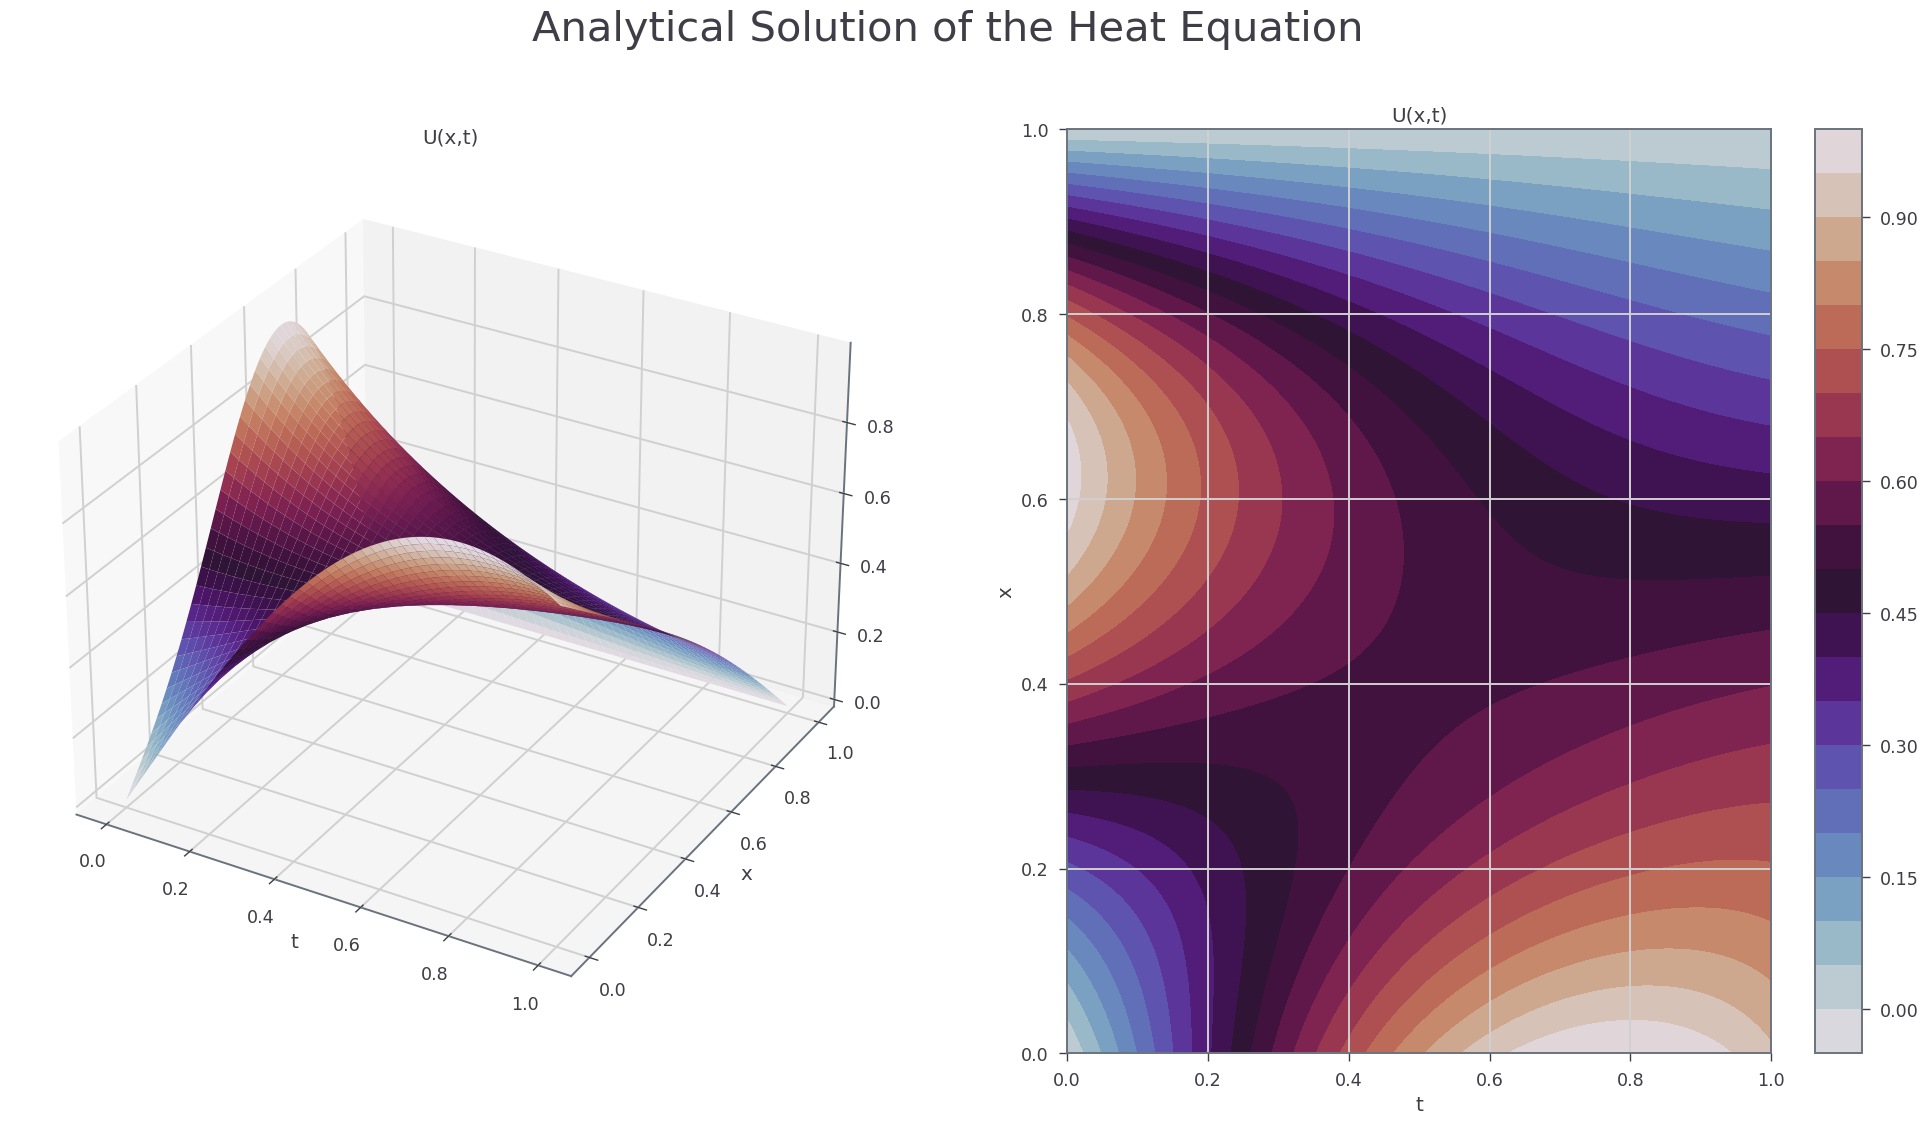

In [43]:
import matplotlib.pyplot as plt
import torch
import scipy
from scipy.integrate import solve_ivp
from torch import nn 
from torch import Tensor           
import torch.autograd as autograd         
from torch.optim import Adam, LBFGS
import numpy as np
#!pip install torchviz
from torchviz import make_dot

#!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=True)

print("CUDA available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("PyTorch version: ", torch.__version__ )

def analytical_sol(x,t,y):
    x_plot =x.squeeze(1) 
    t_plot =t.squeeze(1)
    X,T= torch.meshgrid(x_plot,t_plot)
    F_xt = y
    fig = plt.figure(figsize=(25,12))
    fig.suptitle('Analytical Solution of the Heat Equation', fontsize=30)
   
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    ax1.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="twilight")
    ax1.set_title('U(x,t)')
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')

    cp = ax2.contourf(T,X, F_xt,20,cmap="twilight")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax2.set_title('U(x,t)')
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    plt.show()

def approx_sol(x,t,y):
    X,T= x,t
    F_xt = y
    fig = plt.figure(figsize=(25,15))
    fig.suptitle('NN Approximated Solution of the Heat Equation', fontsize=30)
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    ax1.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="twilight")
    ax1.set_title('U(x,t)')
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')

    cp = ax2.contourf(T,X, F_xt,20,cmap="twilight")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax2.set_title('U(x,t)')
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    plt.show()

# We will approximate the heat equation on the box [0, 1]x[0, 1]:
x_min=0.
x_max=1.
t_min=0.
t_max=1.
#Collocation discretisation of the box, i.e. for the residual term
total_points_x=200
total_points_t=100

#Create mesh
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)
# Create the mesh 
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))#[200,100]
print(x.shape)#[200,1]
print(t.shape)#[100,1]
print(X.shape)#[200,100]
print(T.shape)#[200,100]

x_min_tens = torch.Tensor([x_min]) 
x_max_tens = torch.Tensor([x_max]) 
#To get analytical solution obtained via MATHEMATICA
f_real = lambda x, t:  (1. - 1.*x)*torch.sin(2*t) +( 1.12734*torch.exp(-0.98696*t) - 0.252637*torch.cos(2.*t) - 0.511949*torch.sin(2.*t) )* torch.sin(torch.pi*x)+\
                        ( -0.112278*torch.exp(-3.94784*t) - 0.128324*torch.cos(2.*t) - 0.0650094*torch.sin(2.*t) )* torch.sin(2*torch.pi*x)
# Evaluate real solution on the box domain
U_real=f_real(X,T)
analytical_sol(x,t,U_real) #f_real was defined previously(function)

Since we approximate NN solution on $[0,1]x[0,1]=100x200$ for space and time , respectively, it is necessary to flatten our domain $\Omega$. All input vectors are two-dimensional for space and time. The output is one-dimensional, which later, after reshaping, will result in an approximated solution. For later error estimations, let us prepare the test vector and analytical solution $U$. To do so, we have to flatten input field into a two-dimensional vector $\{x_{i}, t_{i}\}_{i=1}^{20000}$ and one-dimensional output vector $\{U_{test}^{i}\}_{i=1}^{20000}$. Similar setup will be applied for the initial (IC) and boundary conditions (BC).

In [44]:
#Prepare testing data
# Transform the mesh into a 2-column vector
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))#[200x100 -> 20000,2]
U_test=U_real.transpose(1,0).flatten()[:,None] #[200x100 -> 20000,1] # Colum major Flatten (so we transpose it) 

Now it is time to set up vectors on which NN will approximate the desired solution. The initial data at $t=0$ are from 18 points sampled from 100-points time vector, so we obtain 2-column vector $\{U_0^i, x_0^i\}_{i=1}^{18}$.

The boundaries at $x=0$ and $x=1$ consist of 150 points sampled from a 200-points spatial vector. In this way, we obtain the 2-column vector 
 $\{U_b^i, t_0^i\}_{i=1}^{150}$.

Next, we stack IC and BCs vertically into two vectors of the length of 168 points for inputs *X_train_boundaries* and solution on boundaries *U_train_boundaries*.

In [45]:
# Domain bounds
lb=x_test[0] #first value of the mesh
ub=x_test[-1] #last value of the mesh

# Transform the mesh into a 2-column vector
#Left Edge: U(x,0)=sqrt(x)->xmin=<x=<xmax; t=0
left_X=torch.hstack((X[:,0][:,None],T[:,0][:,None])) #[200,2] 
left_U=torch.sqrt(left_X[:,0]).unsqueeze(1) #[200,1]

#Boundary Conditions
#Bottom Edge: U(x_min=0,t) = sin(2x); tmin=<t=<max
bottom_X=torch.hstack([X[0,:][:,None],T[0,:][:,None]]) #[100,2]
bottom_U= torch.sin(2.*(bottom_X[:,1][:,None]))#[100,1]

#Top Edge: U(x_max=1,t) = 0 ; 0=<t=<1
top_X=torch.hstack((X[-1,:][:,None],T[-1,:][:,None])) #[100,2]
top_U=torch.zeros(top_X.shape[0],1) #[100,1]

N_IC=20
idx=np.random.choice(left_X.shape[0],N_IC,replace=False)
X_IC=left_X[idx,:] #[15,2]
U_IC=left_U[idx,:] #[15,1]

#Stack all boundaries vertically
X_BC=torch.vstack([bottom_X,top_X]) #[150,2]
U_BC=torch.vstack([bottom_U,top_U]) #[150,1]

N_BC=200
idx=np.random.choice(X_BC.shape[0],N_BC,replace=False)
X_BC=X_BC[idx,:] #[100,2]
U_BC=U_BC[idx,:] #[100,1]

#Stack all boundaries vertically
X_train_boundaries=torch.vstack([X_IC, X_BC]) #[185,2]
U_train_boundaries=torch.vstack([U_IC, U_BC]) #[185,1]

For the residual term, we have 200x100 = 20000 points from which we sample 10000 points. That is why the solution domain is on $U(x,t)$ are $\{ x_c^i, t_c^i \}_{i=1}^{1000}$. Next, we stack the collocation points inside the domain, $\Omega$, with those for BCs. This way, we have all the necessary arrays and vectors prepared for the training. 

In [46]:
#Collocation Points to evaluate PDE residual
#Choose(Nf) points(Latin hypercube)
N_residual=10000
from pyDOE import lhs 
X_train_residual=lb+(ub-lb)*lhs(2,N_residual)#[1000,2] # 2 as the inputs are x and t
X_train_total=torch.vstack((X_train_residual,X_train_boundaries))#[10000,2] and [100,] -> [10100,2] Add the training points to the collocation points

torch.manual_seed(123)
#Store tensors to GPU
X_train_boundaries=X_train_boundaries.float().to(device)#Training Points (BC)
U_train_boundaries=U_train_boundaries.float().to(device)#Training Points (BC)
X_train_total=X_train_total.float().to(device)#Collocation Points
U_hat = torch.zeros(X_train_total.shape[0],1).to(device)#[10100,1]; needed to loss function
X_train_residual.shape

torch.Size([10000, 2])

We will apply wide, shallow NN architecture with additional skip connections to overcome the vanishing gradient problem. In addition, it is usually that the deeper NN, the more learning goes towards low-frequency features. Thus, there are applied so-called [Fourier Features](https://arxiv.org/pdf/2006.10739.pdf) that prevent the omission of high-frequency functions. The used here mapping is $\gamma(x)=[cos(B\,x), sin(B\,x)]^T$ with $B$ drawn from normal distribution. *tune_beta* is the aggregating gradient accumulator stabilising training by smoothing irregularities and facilitating gradients' flow. The NN's architecture is depicted [here](/images/Residual_net.svg) .

In [47]:
class DenseResNet(nn.Module):

    def __init__(self, dim_in, dim_out, num_resnet_blocks, 
                 num_layers_per_block, num_neurons, activation, 
                 fourier_features, m_freqs, sigma, tune_beta):
        super(DenseResNet, self).__init__()

        self.num_resnet_blocks = num_resnet_blocks
        self.num_layers_per_block = num_layers_per_block
        self.fourier_features = fourier_features
        self.activation = activation
        self.tune_beta = tune_beta

        if tune_beta:
            self.beta0 = nn.Parameter(torch.ones(1, 1)).to(device)
            self.beta = nn.Parameter(torch.ones(self.num_resnet_blocks, self.num_layers_per_block)).to(device)

        else: 
            self.beta0 = torch.ones(1, 1).to(device)
            self.beta = torch.ones(self.num_resnet_blocks, self.num_layers_per_block).to(device)


        self.first1 = nn.Linear(dim_in, num_neurons)
        # nn.init.xavier_uniform_(self.first1.weight.data)
        # nn.init.zeros_(self.first1.bias.data)  
        self.first2 = nn.Linear(dim_in, num_neurons)
        # nn.init.xavier_uniform_(self.first2.weight.data)
        # nn.init.zeros_(self.first2.bias.data)  
        self.first3 = nn.Linear(dim_in, num_neurons)
        # nn.init.xavier_uniform_(self.first3.weight.data)
        # nn.init.zeros_(self.first3.bias.data)  
        self.first4 = nn.Linear(dim_in, num_neurons)
        # nn.init.xavier_uniform_(self.first4.weight.data)
        # nn.init.zeros_(self.first4.bias.data)  
        self.first5 = nn.Linear(dim_in, num_neurons)
        # nn.init.xavier_uniform_(self.first5.weight.data)
        # nn.init.zeros_(self.first5.bias.data)  

        self.resblocks = nn.ModuleList([
            nn.ModuleList([nn.Linear(num_neurons, num_neurons) 
                for _ in range(num_layers_per_block)]) 
            for _ in range(num_resnet_blocks)])

        self.last = nn.Linear(num_neurons, dim_out)

        if fourier_features:
            self.first1 = nn.Linear(2*m_freqs, num_neurons)
            self.first2 = nn.Linear(2*m_freqs, num_neurons)
            self.first3 = nn.Linear(2*m_freqs, num_neurons)
            self.first4 = nn.Linear(2*m_freqs, num_neurons)
            self.first5 = nn.Linear(2*m_freqs, num_neurons)
            self.B = nn.Parameter(sigma*torch.randn(dim_in, m_freqs).to(device)) # to converts inputs to m_freqs

    def forward(self, x):
        if self.fourier_features:
            cosx = torch.cos(torch.matmul(x, self.B)).to(device)
            sinx = torch.sin(torch.matmul(x, self.B)).to(device)
            x = torch.cat((cosx, sinx), dim=1)
            x1 = self.activation(self.beta0*self.first1(x))
            x2 = self.activation(self.beta0*self.first2(x))
            x3 = self.activation(self.beta0*self.first3(x))
            x4 = self.activation(self.beta0*self.first4(x))
            x5 = self.activation(self.beta0*self.first5(x))
            id1 = x1
            id2 = x2
            id3 = x3
            id4 = x4
            id5 = x5

        else:
            x1 = self.activation(self.beta0*self.first1(x))
            x2 = self.activation(self.beta0*self.first2(x))
            x3 = self.activation(self.beta0*self.first3(x))
            x4 = self.activation(self.beta0*self.first4(x))
            x5 = self.activation(self.beta0*self.first5(x))
            id1 = x1
            id2 = x2
            id3 = x3
            id4 = x4
            id5 = x5

        for i in range(self.num_resnet_blocks):
            z1 = self.activation(self.beta[i][0]*self.resblocks[i][0](x1))
            z2 = self.activation(self.beta[i][0]*self.resblocks[i][0](x2))
            z3 = self.activation(self.beta[i][0]*self.resblocks[i][0](x3))
            z4 = self.activation(self.beta[i][0]*self.resblocks[i][0](x4))
            z5 = self.activation(self.beta[i][0]*self.resblocks[i][0](x5))

            for j in range(1, self.num_layers_per_block):
                z11 = self.activation(self.beta[i][j]*self.resblocks[i][j](z1))
                z22 = self.activation(self.beta[i][j]*self.resblocks[i][j](z2))
                z33 = self.activation(self.beta[i][j]*self.resblocks[i][j](z3))
                z44 = self.activation(self.beta[i][j]*self.resblocks[i][j](z4))
                z55 = self.activation(self.beta[i][j]*self.resblocks[i][j](z5))
                z11 = z11 + id1
                z22 = z22 + id2
                z33 = z33 + id3 
                z44 = z44 + id4 
                z55 = z55 + id5 

                for j in range(1, self.num_layers_per_block):
                    z111 = self.activation(self.beta[i][j]*self.resblocks[i][j](z11))
                    z222 = self.activation(self.beta[i][j]*self.resblocks[i][j](z22))
                    z333 = self.activation(self.beta[i][j]*self.resblocks[i][j](z33))
                    z444 = self.activation(self.beta[i][j]*self.resblocks[i][j](z44))
                    z555 = self.activation(self.beta[i][j]*self.resblocks[i][j](z55))

                x =  z111 + z222 + z333 + z444 +z555

        out = self.last(x)

        return out

Fourier_dense_net1 = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=3, 
                        num_layers_per_block=3, num_neurons=25, activation=nn.LeakyReLU(0.65),
                        fourier_features=True, m_freqs=30, sigma=8, tune_beta=True)

PINN = Fourier_dense_net1.to(device)   

In [48]:
x = torch.randn(2,2).to(device).requires_grad_(True)
y = PINN(x)
#make_dot(y, params=dict(list(PINN.named_parameters()))).render("Residual_net", format="png")
make_dot(y, params=dict(list(PINN.named_parameters()))).render("Residual_net_svg", format="svg")

'Residual_net_svg.svg'

The architecture of NN is as follow
![image info](/images/Residual_net_svg.svg)
or in [details](/images/Residual_net_svg.svg)

For the training loop, the ADAM is used, but in the last part, LFBGS tries to find the minimum of the objective function. LFBGS is the second-order optimizer that uses Hessian approximations. 

In [49]:
X_test=x_test.float().to(device) # the input dataset (complete)
U_test=U_test.float().to(device) # the real solution 

lr = 5e-4
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr)#,amsgrad=True, weight_decay=1e-4)#, eps=1e-8)
optimizer_LBFGS = LBFGS(PINN.parameters(), history_size=250, max_iter=5000, line_search_fn="strong_wolfe")
loss_function = nn.MSELoss(reduction ='mean')
loss_evolution = []
iter = 0
steps = 3000
test_loss = torch.tensor([np.Inf]).to(device)

def train():
    x_BC= PINN(X_train_boundaries) 
    loss_BC=loss_function(x_BC, U_train_boundaries)
    g=X_train_total.clone() 
    g.requires_grad=True #Enable differentiation
    U=PINN(g)
    U_x_t = autograd.grad(U,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
    U_xx_tt = autograd.grad(U_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0] #second derivative
    U_t=U_x_t[:,[1]]    # we select the 2nd element for t (the first one is x) (Remember the input X=[x,t]) 
    U_xx=U_xx_tt[:,[0]] # we select the 1st element for x (the second one is t) (Remember the input X=[x,t]) 
    U=U_t - 0.1*U_xx    # updated approximation
    loss_PDE = loss_function(U,U_hat)#U_hat=0 if you putt the equation on the LHS and leave 0 on the RHS
    loss = loss_BC + loss_PDE
    return loss

LOSSES = [] 
TEST_LOSSES = []   
ITERACJE = []
U_anim = np.zeros((total_points_x,total_points_t, steps))

for i in range(steps):
    optimizer.zero_grad()  
    loss = train()

    loss.backward()  
    optimizer.step()
    
    if test_loss < 0.00085:
        def closure():
            optimizer_LBFGS.zero_grad()  
            loss = train()
            loss.backward()
            return loss
        optimizer_LBFGS.step(closure)
        loss = closure()
        
    U_anim[:,:,i]=PINN(X_test).reshape(shape=[total_points_t,total_points_x]).transpose(1,0).detach().cpu()
    iter += 1
    if i%(steps/100)==0:
        
        with torch.no_grad():
            test_loss = loss_function(PINN(X_test),U_test)
            LOSSES.append(loss.detach().cpu().numpy())
            TEST_LOSSES.append(test_loss.detach().cpu().numpy())
        ITERACJE.append(iter+1)    
        print(iter+1,': ', loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())

2 :  18.53955 --- 0.06709361
32 :  0.8896935 --- 0.04381743
62 :  0.481117 --- 0.03671035
92 :  0.35783 --- 0.031787675
122 :  0.28494364 --- 0.02816754
152 :  0.24353798 --- 0.024423711
182 :  0.21444042 --- 0.020625979
212 :  0.18254764 --- 0.018079843
242 :  0.16046125 --- 0.015256447
272 :  0.14250416 --- 0.012951539
302 :  0.13113564 --- 0.011176716
332 :  0.119706966 --- 0.009897727
362 :  0.10976271 --- 0.008707472
392 :  0.09977265 --- 0.007709911
422 :  0.092895955 --- 0.006790537
452 :  0.087770306 --- 0.006105939
482 :  0.08175637 --- 0.0055712964
512 :  0.07681111 --- 0.005096008
542 :  0.07305897 --- 0.004747604
572 :  0.069707744 --- 0.0044096136
602 :  0.06569948 --- 0.0041057346
632 :  0.06255437 --- 0.0038769946
662 :  0.058731414 --- 0.0035679496
692 :  0.055214517 --- 0.0033223007
722 :  0.052800767 --- 0.0030961563
752 :  0.050672162 --- 0.0028557307
782 :  0.048827715 --- 0.0026932762
812 :  0.04760083 --- 0.0026106844
842 :  0.04679454 --- 0.0025498087
872 :  0.04

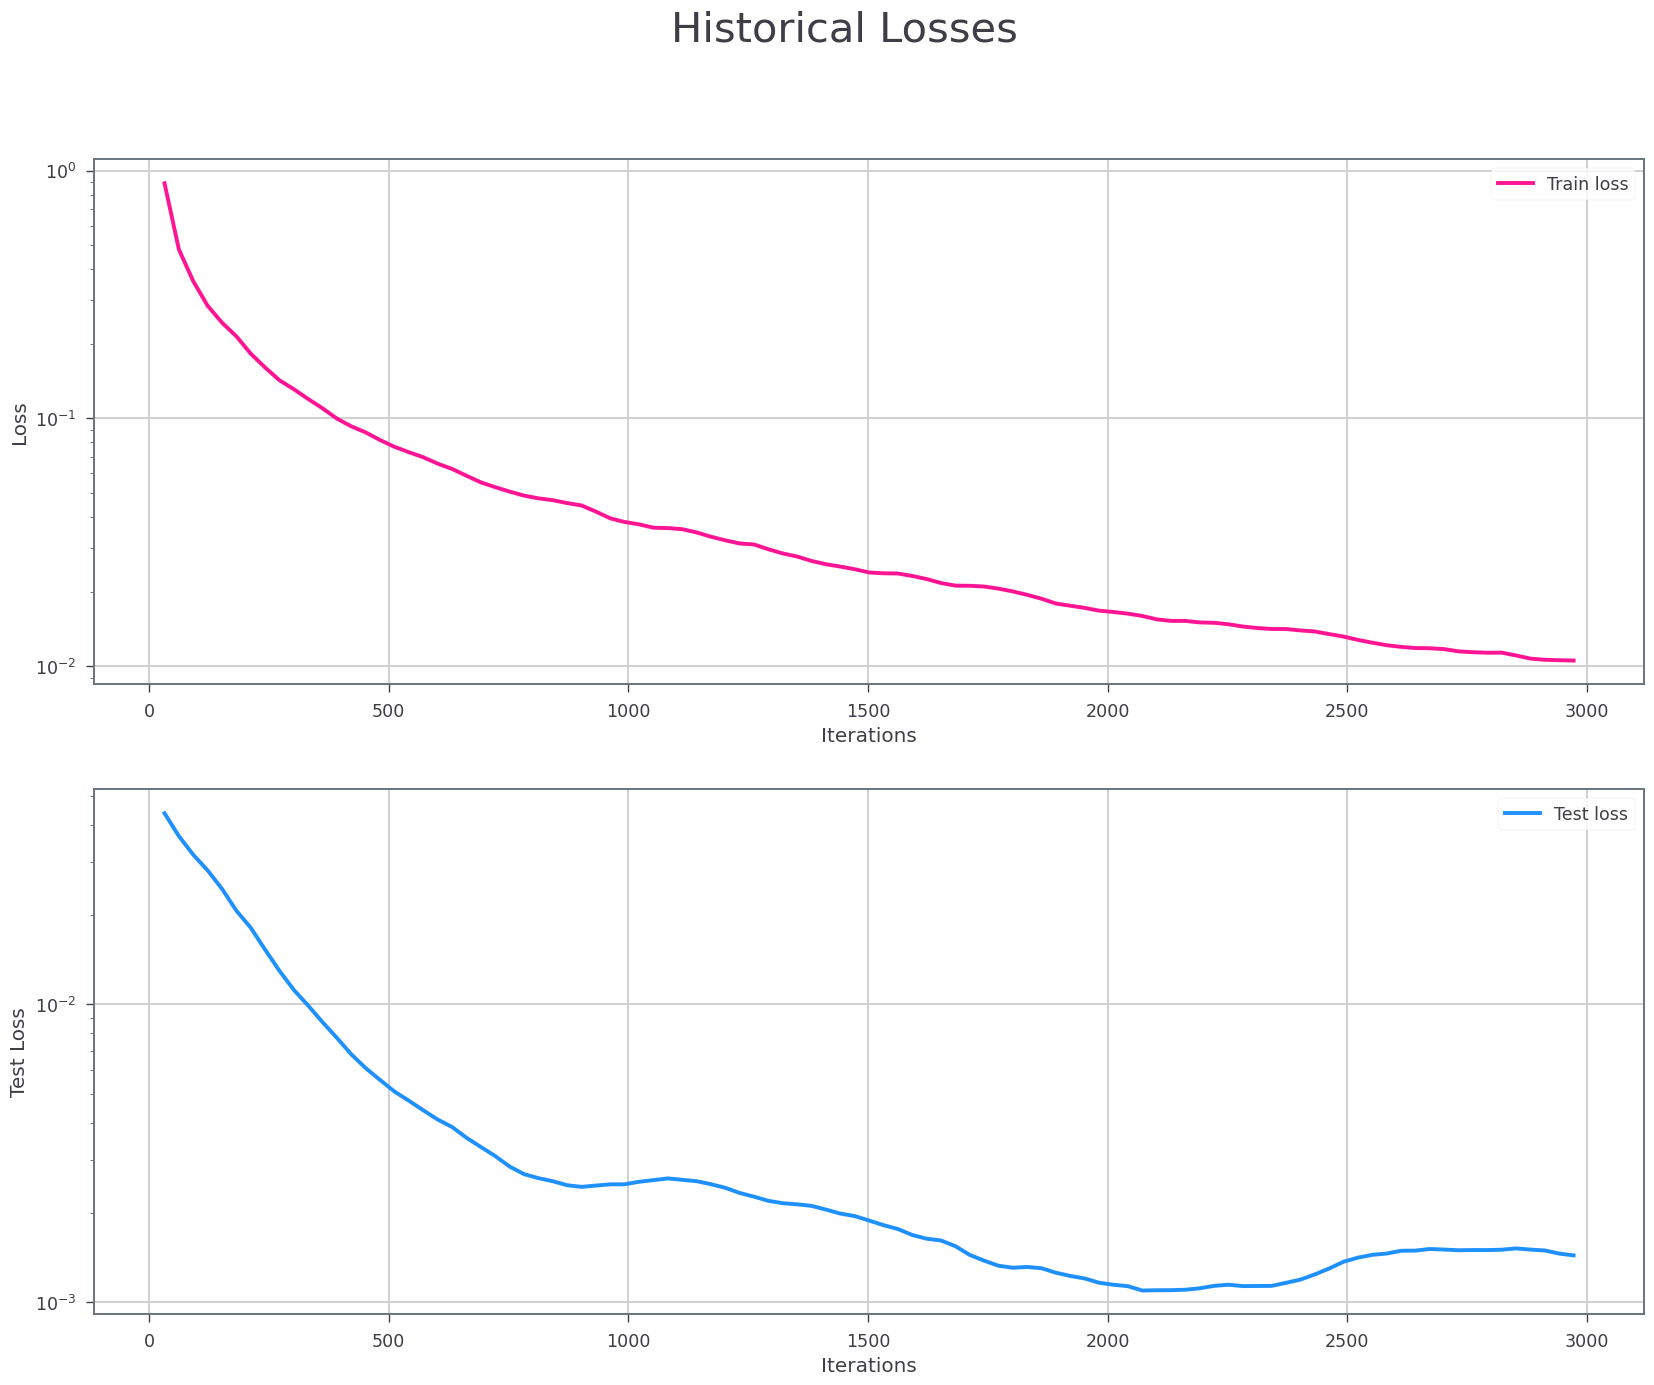

In [50]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,15))
fig.suptitle('Historical Losses', fontsize=30)
ax1.semilogy(ITERACJE[1:], LOSSES[1:], c='deeppink',linewidth=2.8, label='Train loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Iterations')
ax1.legend()

ax2.semilogy(ITERACJE[1:], TEST_LOSSES[1:],c='dodgerblue',linewidth=2.8, label='Test loss')
ax2.set_ylabel('Test Loss')
ax2.set_xlabel('Iterations')
ax2.legend()
plt.show()

To obtain better results, it is advesible to extend traing to LFBGS part, however the usage of this optimisation algorithm is very time-consuming.

/tmp/ipykernel_21479/1662213473.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(cp) # Add a colorbar to a plot


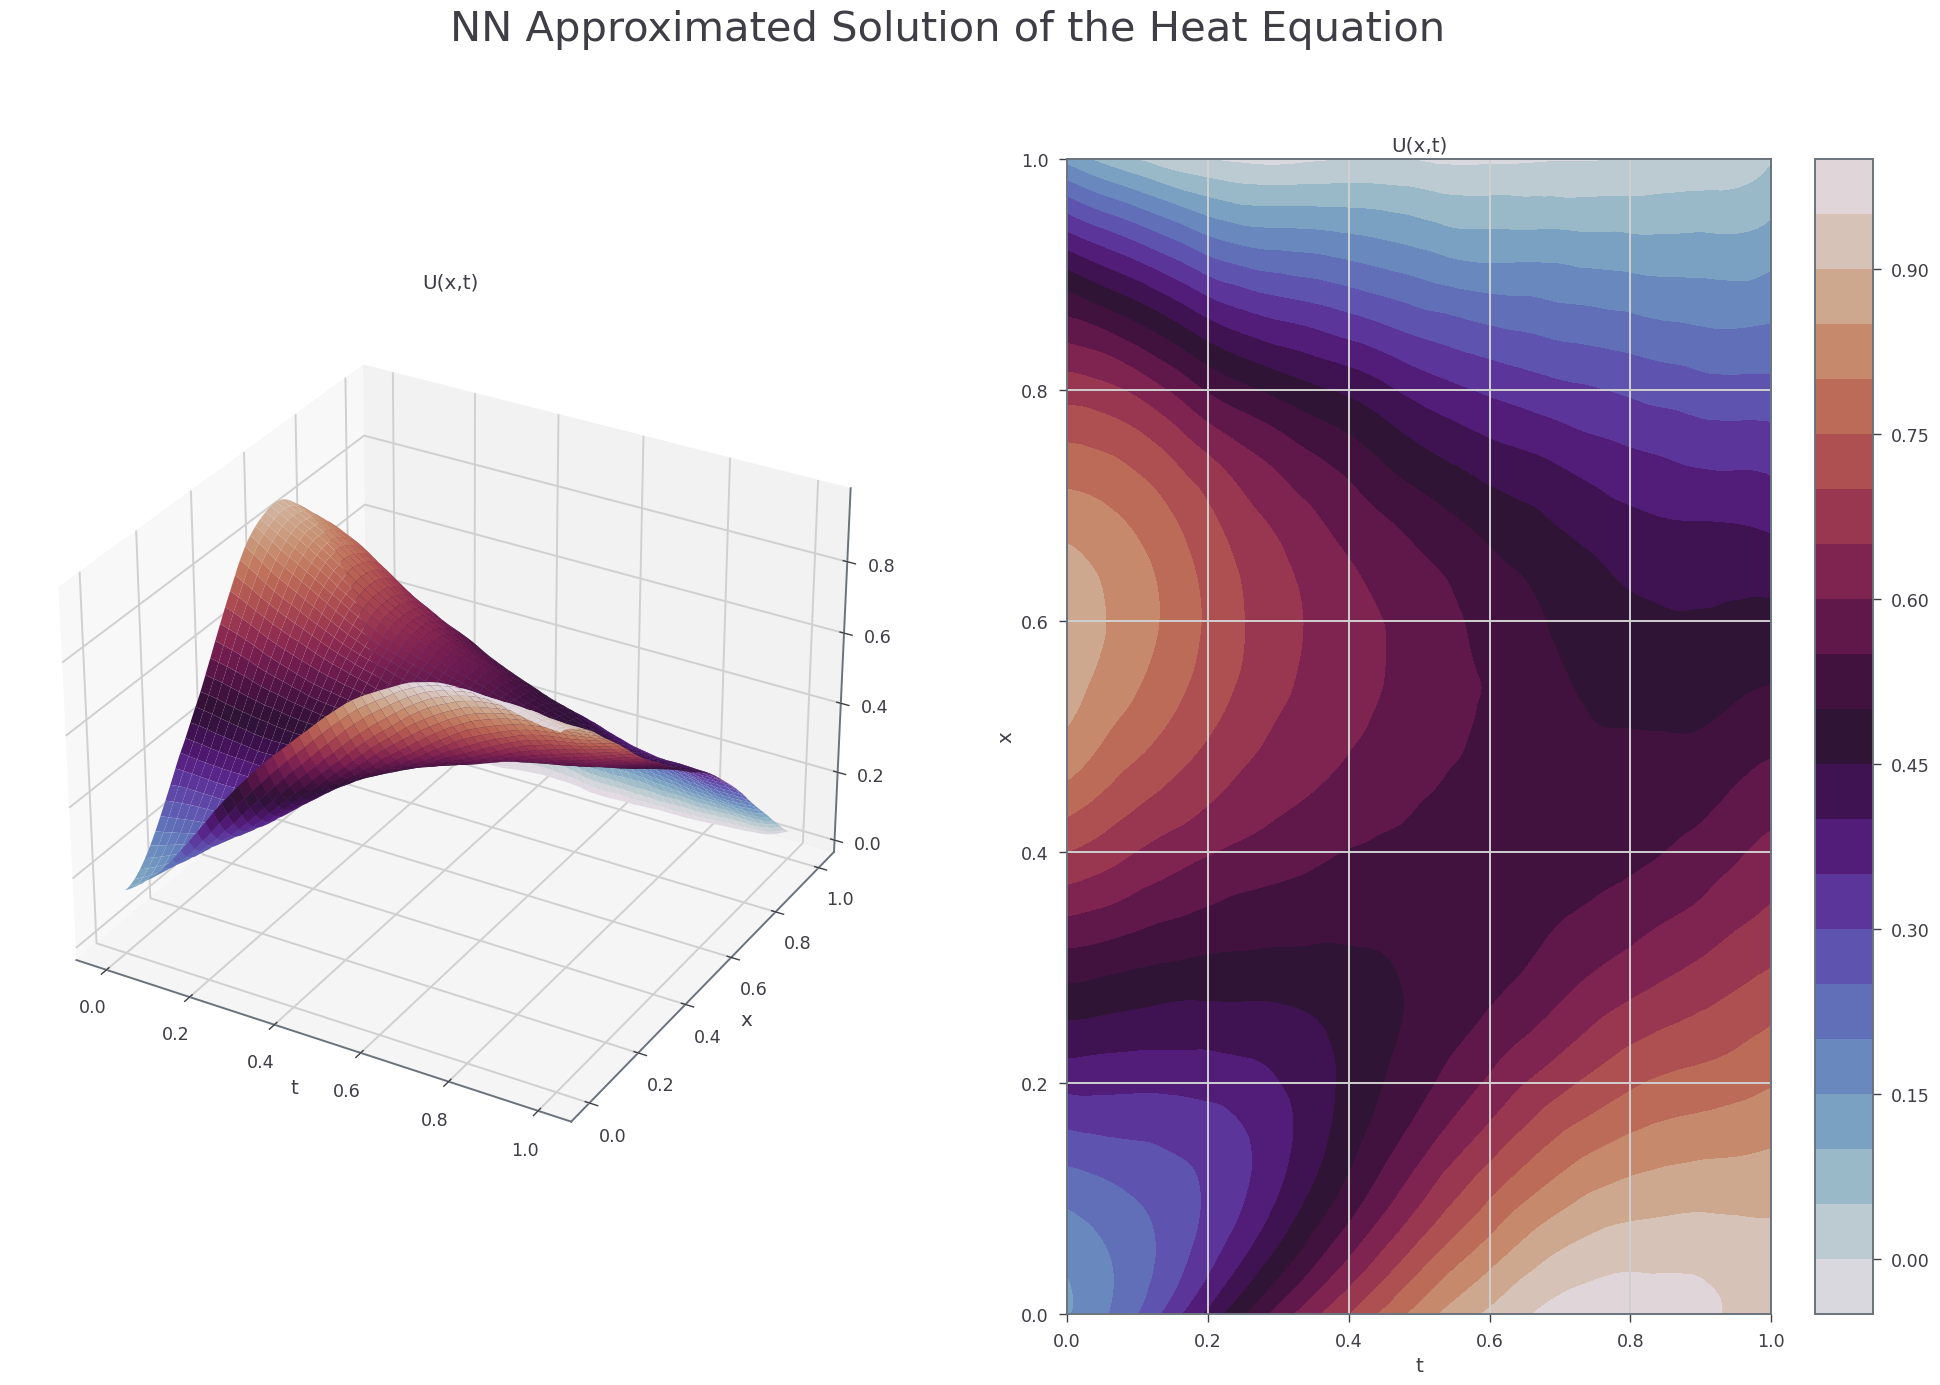

In [13]:
U1=PINN(X_test)
x1=X_test[:,0]
t1=X_test[:,1]

arr_x1=x1.reshape(shape=[total_points_t,total_points_x]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[total_points_t,total_points_x]).transpose(1,0).detach().cpu()
arr_U1=U1.reshape(shape=[total_points_t,total_points_x]).transpose(1,0).detach().cpu()
arr_U_test=U_test.reshape(shape=[total_points_t,total_points_x]).transpose(1,0).detach().cpu()

approx_sol(arr_x1,arr_T1,arr_U1)

It is effective to visualise the learning process. There are two animations below for 3-D and contour plots.<br>
![image info](/images/plot_contour_animation_funcanimation_2.gif)


The results of PINN is not as accurate as those obtained by numerical methods (finite difference or Method of Lines), but it shows that this novel approach works and is very promising for further research.<br>

### ANIMATIONS
If you are interested in creating animations read the further part of the post.

### Contour plot

In [ ]:
#!conda install -c conda-forge ffmpeg
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
#import networkx as nx
from matplotlib.animation import FuncAnimation, PillowWriter, MovieWriter 
from IPython.display import HTML

#Contour plt
fps = 20 # frame per sec
frn = 1# frame number of the animation; the lower value the more frames

xarray = []
for i in range(steps):
    if i%frn == 0:
        xarray.append(U_anim[:,:,i])
carray = np.einsum('kil->ilk', np.array(xarray))

fig, ax = plt.subplots(figsize=(20,18))
fig.suptitle('Solution of Approximated Heat Equation', fontsize=30)
def animate(i):
    ax.clear()
    ax.contourf(T.numpy(), X.numpy(),carray[:,:,i], 30, cmap="twilight")
ani_2 = animation.FuncAnimation(fig, animate, carray.shape[2], interval=500, repeat=False)
fn = 'plot_contour_animation_funcanimation'
#ani_2.save(fn+'.gif',writer='imagemagick',fps=fps)
ani_2.save(fn+'.mp4',writer='ffmpeg',fps=fps)

To deploy plot in notebook

In [ ]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
plt.rcParams['animation.html'] = 'html5'
ani_2

#### 3-D surface plot
This is how to creat top page surface animation.

In [ ]:
fps = 20 # frame per sec
frn = 10# frame number of the animation; the lower value the more frames

xarray = []
for i in range(steps):
    if i%frn == 0:
        xarray.append(U_anim[:,:,i])
carray = np.einsum('kil->ilk', np.array(xarray))


def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(T.numpy(), X.numpy(), carray[:,:,frame_number], cmap="twilight")


fig = plt.figure(figsize=(20,18))
fig.suptitle('Solution of Approximated Heat Equation', fontsize=30)
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(T.numpy(), X.numpy(), carray[:,:,0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,1.1)
ani = animation.FuncAnimation(fig, update_plot, steps//frn, fargs=(carray, plot), interval=5000/fps)

ax.set_title('$U(x,t)_{approximated}$')
ax.set_xlabel('t')
ax.set_ylabel('x')
fn = 'plot_surface_animation_funcanimation'
ani.save(fn+'.mp4',writer='ffmpeg',fps=fps)
ani.save(fn+'.gif',writer='imagemagick',fps=fps)

In the next post, I will look at the inverse problem.